In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from base import BaseDataLoader
import pandas as pd
import gzip
import numpy as np
import re
import pickle
import random
from gensim.parsing.preprocessing import remove_stopwords

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable

In [3]:
from skorch import NeuralNetClassifier
import torch.optim as optim

In [4]:
class AmznDataLoader():
    def __init__(self):
        df = self.getDF('./data/reviews_Amazon_Instant_Video_5.json.gz')
#         display(df)
#         print(self.df.loc[0][['overall','reviewText']])
        df = df[['reviewText', 'overall']]
        df['reviewText'] = df['reviewText'].apply(lambda x : self.title_parsing(x))
        X = df['reviewText']
        y = df['overall']-1
        self.weight_matrix = self.get_weight_matrix(X)
        _, self.idx2word = self.buildCorpus(X)
        X = self.indicesMatrix(X)
        self.data_features = X
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def get_attention_mask(self):
        index_matrix = data_loader.data_features
        mask = (index_matrix!=0)
        mask[:,-1] = False
        attention_weigths = np.random.random(index_matrix.shape).round(1) * 2 + 3
        attention_weigths[~mask] = float('-inf')
        attention_weigths = softmax(attention_weigths, axis=1)
        return attention_weigths

    def title_parsing(self, title):  
        # remove stop words and tokenization 
        title = re.sub('[^a-zA-Z]', ' ', str(title))
        title = title.lower()
        title = remove_stopwords(title)  ## remove stop words, corpus size 52680            
        title = title.split()
        title = [word for word in title if len(word) >1 ]
        return title

    def parse(self, path):
        g = gzip.open(path, 'rb')
        for l in g:
            yield eval(l)

    def getDF(self, path):
        i = 0
        df = {}
        for d in self.parse(path):
            df[i] = d
            i += 1
        return pd.DataFrame.from_dict(df, orient='index')        

    def buildCorpus(self, X):
        '''
        return a dictionary with 'word' and its index in corpus as key and value respectively
        '''
        word2idx = {}
        idx2word = [] ## alternatively use if.. condition
        idx = 0 
        for row in X:
            for word in row:
                if word not in word2idx:
                    idx2word.append(word)                
                    word2idx[word] = len(idx2word) - 1
#             pickle.dump(word2idx, open('./data/corpusDict.txt', 'wb'))
        return word2idx, idx2word  


    def indicesMatrix(self, X):
        '''
        return matrix (num_reviews, maxNumberWords) such that review text transformed to index
        '''
        word2idx, _ = self.buildCorpus(X)
#             word2idx = pickle.load(open('./data/corpusDict.txt', 'rb'))
        ## 53008 words in corpus

        corpusSize = len(word2idx) 

        maxNumberWords = sorted(len(x) for x in X)[-1]
#             print ("maximum", maxNumberWords)

        index_matrix = np.zeros((X.shape[0], maxNumberWords))          
        for i, row in enumerate(X):
            for j, word in enumerate(row):
#                 try:
#                     index_matrix[i,j] = word2idx[word]
#                     words_found += 1
#                 except KeyError:
#                     index_matrix[i,j] = corpusSize     
                index_matrix[i,j] = word2idx[word]
        if maxNumberWords % 2 == 1:
            x0 = np.full((index_matrix.shape[0], 1), maxNumberWords)
            index_matrix = np.hstack((index_matrix, x0))
        return index_matrix

    def get_weight_matrix(self, X):
        '''
        return matrix contains embedding for word in corpus/review text
        Note that the word cannot be found in the glove returns ?? as embedding
        '''

        glove = {}

        with open(f'./data/glove.6B.50d.txt', 'rb') as f:
            for l in f:
                line = l.decode().split()           
                word = line[0]
    #            words.append(word)
    #             word2idx[word] = idx
    #            idx += 1
                vect = np.array(line[1:]).astype(np.float)
    #             vectors.append(vect)
    #     vectors = np.reshape(vectors, (400000, 50))
                glove.update({word:vect})
    #     glove = {word2idx[w]: vectors[word2idx[w]] for w in words}  # alternatively generate weights_matrix directly

        target_vocab, _ = self.buildCorpus(X)
        #except
        #exceptKey = list(set(list(glove.keys())).difference(list(target_vocab.keys())))  ## 
        matrix_len = len(target_vocab)
        weights_matrix = np.zeros((matrix_len, 50))
        words_found = 0
        words_not_found = 0
        for i, word in enumerate(target_vocab):
            try: 
                weights_matrix[i] = glove[word]
                words_found += 1
            except KeyError:
                words_not_found += 1
                weights_matrix[i] = np.random.normal(scale=0.6, size=(50,))

        print(words_not_found)
        return  weights_matrix

In [5]:
data_loader = AmznDataLoader()

9776


In [6]:
df = data_loader.getDF('./data/reviews_Amazon_Instant_Video_5.json.gz')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2.0,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5.0,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1.0,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4.0,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5.0,Robson green and great writing,1234310400,"02 11, 2009"


In [7]:
data_loader.idx2word
corpus = os.linesep.join(data_loader.idx2word)
print(type(corpus))
with open("text_for_bert.txt", "w", encoding='utf-8') as fp:
    fp.write(corpus)
    

<class 'str'>


In [7]:
np.count_nonzero(data_loader.X_train)/(data_loader.X_train.shape[0]*data_loader.X_train.shape[1])

0.02755311660771048

In [8]:
data_loader.X_train.shape
# data_loader.buildCorpus()

(29700, 1502)

In [9]:
weight_matrix = data_loader.weight_matrix
import sys
print(sys.getsizeof(weight_matrix)/(2**20))

# print(weight_matrix[0])
# print(weight_matrix.shape)

20.086395263671875


In [10]:
# pickle.dump(weight_matrix,  open('./data/GloveMatrix.npy', 'wb'))

In [11]:
# todo reset parameters for linear layer
class ReviewModel(nn.Module):
    def __init__(self, max_length, batch_size):
        super(ReviewModel, self).__init__()
        weights_matrix = data_loader.weight_matrix
        self.max_length = max_length
        self.batch_size = batch_size
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(weights_matrix), freeze=False)
#        self.embedding = nn.Embedding(weights_matrix.shape[0],weights_matrix.shape[1])
#         self.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.drop1 = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv1d(in_channels=50, out_channels=200, kernel_size=4, padding=2).double()
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=200, kernel_size=5, padding=2).double()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.drop2 = nn.Dropout(p=0.15)
        
        self.rnn = nn.GRU(input_size=400, hidden_size=100, num_layers=1, batch_first=False)  #
#        self.fc1 =nn.Linear(in_features=1501*100, out_features = 400)
        self.fc1 =nn.Linear(in_features=(max_length//2)*100, out_features = 400)
        self.drop3 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(in_features=400, out_features=5)
        
    def forward(self, x):
#         print("input tensor", x.size())
        x = self.embedding(x)
#         print("after embedding", x.size())
        x = self.drop1(x)
#        print(x)
        x = x.view(-1,50,self.max_length)  # input(N,C_in,L) to conv1d
        x1 = F.relu(self.conv1(x))
#         print("x1 shape", x1.size())
        x2 = F.relu(self.conv2(x))
#         print("x2 shape ", x2.size())

        x1 = self.maxpool(x1)
#         print("x1 shape", x1.size())        
        x2 = self.maxpool(x2)
#         print("x2 shape", x2.size())        
        x = torch.cat((x1,x2), 1)
        x = self.drop2(x)
        
        x = x.view((self.max_length//2),-1, 400).float()#### change dimensionality
        
        hidden = Variable(torch.cuda.FloatTensor(1, batch_size, 100).uniform_()) 
        
#        print("before rnn ", x.size(), "hidden size ",hidden.size())

        output, _ = self.rnn(x,hidden)
#         print("AFTER rnn ",output.size())
        
        x = output.contiguous().view(-1, (self.max_length//2)*100)
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = self.fc2(x)
        return x
    
    
#     def create_emb_layer(self, weights_matrix, non_trainable=True):
#         num_embeddings, embedding_dim = weights_matrix.shape
#         emb_layer = nn.Embedding(num_embeddings, embedding_dim)
#         emb_layer.load_state_dict({'weight': weights_matrix})
#         if non_trainable:
#             emb_layer.weight.requires_grad = False

#         return emb_layer, num_embeddings, embedding_dim
    

In [ ]:
# from pytorch_pretrained_bert import BertTokenizer, BertModel
# from flair.embeddings import BertEmbeddings
# bert_embedding = BertEmbeddings('bert-base-uncased')
# from flair.data import Sentence
# sentence = Sentence('hello world')
# emb = bert_embedding.embed(sentence)
# for token in emb:
#     print(token.embedding.detach().cpu().numpy().shape)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')
# model.eval()

In [12]:
class ReviewModelwithBert(nn.Module):
    def __init__(self, max_length, batch_size, weights_matrix):
        super(ReviewModelwithBert, self).__init__()
#         weights_matrix = data_loader.weight_matrix
        self.max_length = max_length
        self.batch_size = batch_size
#         self.embedding = nn.Embedding.from_pretrained(torch.tensor(weights_matrix), freeze=False)
        vocab_size =  weights_matrix.shape[0]
        embedding_dim = weights_matrix.shape[1]
        self.embedding = nn.Embedding(weights_matrix.shape[0],weights_matrix.shape[1]).double()
#         self.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.drop1 = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv1d(in_channels=50, out_channels=200, kernel_size=4, padding=2).double()
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=200, kernel_size=5, padding=2).double()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.drop2 = nn.Dropout(p=0.15)
        
        self.rnn = nn.GRU(input_size=400, hidden_size=100, num_layers=1, batch_first=False)  #
#        self.fc1 =nn.Linear(in_features=1501*100, out_features = 400)
        self.fc1 =nn.Linear(in_features=(max_length//2)*100, out_features = 400)
        self.drop3 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(in_features=400, out_features=5)
        
    def forward(self, x):
#         print("input tensor", x.size())
#         attn_weigths = F.softmax(x, dim=1)
        x = self.embedding(x)
#         print("after embedding", x.size())
        
        x = self.drop1(x)
#        print(x)
        x = x.view(-1,50,self.max_length)  # input(N,C_in,L) to conv1d
        x1 = F.relu(self.conv1(x))
#         print("x1 shape", x1.size())
        x2 = F.relu(self.conv2(x))
#         print("x2 shape ", x2.size())

        x1 = self.maxpool(x1)
#         print("x1 shape", x1.size())        
        x2 = self.maxpool(x2)
#         print("x2 shape", x2.size())        
        x = torch.cat((x1,x2), 1)
        x = self.drop2(x)
        
        x = x.view((self.max_length//2),-1, 400).float()#### change dimensionality
        
        hidden = Variable(torch.cuda.FloatTensor(1, batch_size, 100).uniform_()) 
        
#        print("before rnn ", x.size(), "hidden size ",hidden.size())

        output, _ = self.rnn(x,hidden)
#         print("AFTER rnn ",output.size())
        
        x = output.contiguous().view(-1, (self.max_length//2)*100)
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = self.fc2(x)
        return x
    
    def get_tensors(self, word):
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # Tokenized input
        tokenized_text = tokenizer.tokenize(word)

        # Mask a token that we will try to predict back with `BertForMaskedLM`

        # Convert token to vocabulary indices
        input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
        # Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
        # print(len(tokenized_text))
        tokens = []
        input_type_ids = []
        tokens.append("[CLS]")
        input_type_ids.append(0)
        for token in tokenized_text:
            tokens.append(token)
            input_type_ids.append(0)
        tokens.append("[SEP]")
        input_type_ids.append(0)

        input_mask = [1] * len(input_ids)
        seq_length  = 512
        # print('input_ids ', len(input_ids))
        # print('input_mask ', len(input_mask))
        # print('input_type_ids ', len(input_type_ids))
        # Zero-pad up to the sequence length.
        while len(input_ids) < seq_length:
            input_ids.append(0)
        while len(input_mask) < seq_length:
            input_mask.append(0)
        while len(input_type_ids)  < seq_length:
            input_type_ids.append(0)
        assert len(input_ids) == seq_length
        assert len(input_mask) == seq_length
        assert len(input_type_ids) == seq_length, len(input_type_ids)
        # Convert inputs to PyTorch tensors
        input_ids = torch.tensor([input_ids])
        input_mask = torch.tensor([input_mask])
        input_type_ids = torch.tensor([input_type_ids])
        return input_ids, input_mask, input_type_ids
    
    
    def get_bert_embedding(self, word, model):
        input_ids, input_mask, input_type_ids = self.get_tensors(word)

#         print(type(indexed_tokens))
#         for _ in range(510-len(indexed_tokens)):
#             indexed_tokens.append(0)
#         segments_tensors = np.zeros((510))
#         non_zeros = np.count_nonzero(indexed_tokens)
#         segments_tensors[:non_zeros] = 1
#         indexed_tokens = torch.tensor(indexed_tokens).long()
#         segments_tensors = torch.tensor(segments_tensors).long()

#         print(indexed_tokens.size())
#         print(segments_tensors.size())
        encoded_layers, pooled_output = model(input_ids, input_type_ids, input_mask)
#         print(encoded_layers, pooled_output)
        return pooled_output
    def embedding_bert(self, x, seq_length, embedding_size, model):
        #batch_size, seq-length
        #transofrm into batch_size, seq_length, embedding size
        #idx2word search
        emb = torch.zeros(batch_size, seq_length, embedding_size)
        for i in range(batch_size):
            phrase_length = np.count_nonzero( x[i,:].detach().cpu().numpy())-1
            for j in range(phrase_length):
                word = data_loader.idx2word[x[i,j].detach().cpu().numpy().astype(np.int)]
                emb[i, j,:] = self.get_bert_embedding(word, model)
        return emb

In [13]:
from skorch.callbacks import EpochScoring, PrintLog, ProgressBar, LRScheduler, EarlyStopping
from sklearn.metrics import accuracy_score

In [14]:
def ds_accuracy(net, ds, y=None):
    # assume ds yields (X, y), e.g. torchvision.datasets.MNIST
    y_true = [y for _, y in ds]
    y_pred = net.predict(ds)
    return sklearn.metrics.accuracy_score(y_true, y_pred)


callbacks = [
    ('lrs',LRScheduler()),
    ('est',EarlyStopping()) 
]

batch_size = 256
device = torch.device("cuda:0")
model = ReviewModelwithBert(data_loader.X_train.shape[1], batch_size, data_loader.weight_matrix).to(device)
net = NeuralNetClassifier(model,## change dimensionality
                          iterator_train__drop_last = True,
                          iterator_valid__drop_last = True,
                          iterator_train__shuffle = True,
                          iterator_valid__shuffle = True,
                          max_epochs=20, 
                          lr=0.01,
                          criterion = nn.CrossEntropyLoss, 
                          optimizer=optim.Adam,
                          batch_size = batch_size,
                          callbacks = callbacks,
                          device = torch.device('cuda:0')
                          )


In [15]:
inputs = torch.from_numpy(data_loader.X_train).long().to(device)
labels = torch.tensor(data_loader.y_train.values).long().to(device)

# rest = inputs.size()[0] % batch_size
# print(rest)
# print(inputs.size())
# inputs = inputs[:-rest]
# print(inputs.size()[0]/batch_size)
# print(inputs.shape)
# labels = labels[:-rest]

net.fit(inputs, labels)


  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1      237.4966       0.5617        1.2024  195.9338
      2        1.2023       0.5613        1.2019  195.7959
      3        1.2029       0.5615        1.2032  196.6091
      4        1.2022       0.5620        1.2037  195.8881
      5        1.2019       0.5627        1.2019  195.7805
      6        1.2025       0.5608        1.2043  195.9226
      7        1.2019       0.5623        1.2017  196.7184
      8        1.2020       0.5628        1.2006  197.0827
      9        1.2020       0.5617        1.2025  197.1906
     10        1.2022       0.5615        1.2023  195.0380
     11        1.2015       0.5611        1.2038  197.0550
     12        1.2031       0.5623        1.2026  196.1263
Stopping since valid_loss has not improved in the last 5 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ReviewModelwithBert(
    (embedding): Embedding(52655, 50)
    (drop1): Dropout(p=0.5)
    (conv1): Conv1d(50, 200, kernel_size=(4,), stride=(1,), padding=(2,))
    (conv2): Conv1d(50, 200, kernel_size=(5,), stride=(1,), padding=(2,))
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop2): Dropout(p=0.15)
    (rnn): GRU(400, 100)
    (fc1): Linear(in_features=75100, out_features=400, bias=True)
    (drop3): Dropout(p=0.1)
    (fc2): Linear(in_features=400, out_features=5, bias=True)
  ),
)

In [18]:
inputs = torch.from_numpy(data_loader.X_test).long().to(device)
predictions = net.predict(inputs)

In [32]:
# path = './data/'
# net.save_params(f_params = path+'model.pkl',
#                 f_optimizer = path+'optimizer.pkl',
#                 f_history = path+'history.json')

OSError: [Errno 122] Disk quota exceeded

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(data_loader.y_test[:-2], predictions)

0.5660021551724138

In [ ]:
# m = data_loader.indicesMatrix()
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

In [28]:
import matplotlib.pyplot as plt
def plot_losses(tr_loss, val_loss):
    plt.plot(tr_loss, label="training")
    plt.plot(val_loss, label="validation")
    plt.legend()
    plt.show()

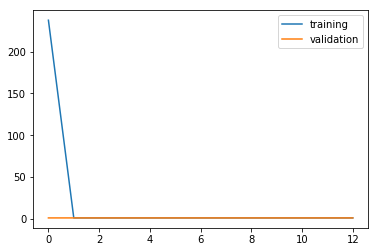

In [30]:
#todo plot losses
#todo plot accuracy
#todo confusion matrix
history = net.history
train_losses = history[:, 'train_loss']
valid_losses = history[:, 'valid_loss']

# accuracy = history[:, 'accuracy']
plot_losses(train_losses, valid_losses)

In [ ]:
y

In [ ]:
w = torch.tensor(weights_matrix).double()

In [ ]:
w

In [ ]:
Variable(w.double())